# Keras LSTM Regression model with daily return  

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [75]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='KerasLSTMRegressionPriceChange'

predict_n = 10

In [76]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,NextPriceChange,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.013555,0.013679,0.619962,0.394439,0.596761,0.496869,higher,0.012863,0.383222,lower
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.013587,0.013637,0.619512,0.394997,0.595125,0.477865,lower,0.013540,0.426279,higher
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.013619,0.013618,0.619054,0.395653,0.594787,0.474037,higher,0.013508,0.419933,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.013656,0.013600,0.618669,0.396346,0.594843,0.474674,lower,0.013540,0.421875,higher
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.013658,0.013496,0.617898,0.397285,0.592643,0.449242,lower,0.013666,0.453439,higher


In [77]:
print(len(data_wrapper.df))

14788


## Prepare Data

In [78]:
y_column = 'NextPriceChange'

seq_len = 10
n_splits=5
val_size = 0.2

features = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 
            'EMA(14)', 'SMA(10)', 'SMA(20) - SMA(10)','PercentageDiff', 'LowLen', 'RSI_diff', 'BodyLen', 'Volume_diff']
datasets_splits = data_wrapper.get_datasets(n_splits=n_splits, val_size=val_size, sequences=True, seq_len=5, y_column=y_column, features_list=features)

datasets_splits.shape

(5, 6)

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

## Model 

In [79]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_regression_trainer import KerasRegressionTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=features,
    learning_rate = 0.001,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 100,
    n_splits = n_splits,
    val_size = val_size,
)

group_name = f"[{quotation}] {seq_len}-sequences : {len(features)} features  -> predict:{predict_n}, {n_splits} splits {val_size} val"


for split_id, split in tqdm(enumerate(datasets_splits)):
    #run = wandb.init(project='StockRegressionKerasLSTM', config=config_dict, group=group_name, name=f"Split {split_id+1}")
    
    (X_train, X_val, X_test, y_train, y_val, y_test) = split
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(config_dict['batch_size'])
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

    model = LSTMModel(config_dict, seq_len, len(features), output_dim=1,
                      learning_rate=config_dict['learning_rate'], loss='mse', metrics=['mae'])
    
    trainer = KerasRegressionTrainer(model, project_label=project_label, use_wandb=True)
    trainer.train(train_set, val_set)


0it [00:00, ?it/s]

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegressionPriceChange/runs/1jeyelwg
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegressionPriceChange/runs/1cv69ph1
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegressionPriceChange/runs/25xq4z7y
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegressionPriceChange/runs/3pdtta0x
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegressionPriceChange/runs/l70brwil


### Train a model with the full training set (train + validation) 

In [80]:
config_dict['n_epochs'] = 150

full_train_set = train_set.concatenate(val_set)
final_model = LSTMModel(config_dict, seq_len, len(features), output_dim=1,
                      learning_rate=config_dict['learning_rate'], loss='mse', metrics=['mae'])
trainer = KerasRegressionTrainer(model, project_label=f"{project_label} full training-set")
trainer.train(full_train_set, val_set=test_set)

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegressionPriceChange%20full%20training-set/runs/hx0pauew


{'prices_plot': <wandb.sdk.data_types.Image at 0x1ed16a297c8>}

## Metrics and plots

In [81]:
test_index = len(X_train) + len(X_val)

test_start_price = data_wrapper.get_unscaled_values(data_wrapper['NextPrice'], 'NextPrice')[test_index]
test_start_price

159.020004

In [82]:
target_returns = data_wrapper.get_unscaled_values(labels, 'NextPriceChange')
predicted_returns = data_wrapper.get_unscaled_values(predictions, 'NextPriceChange')

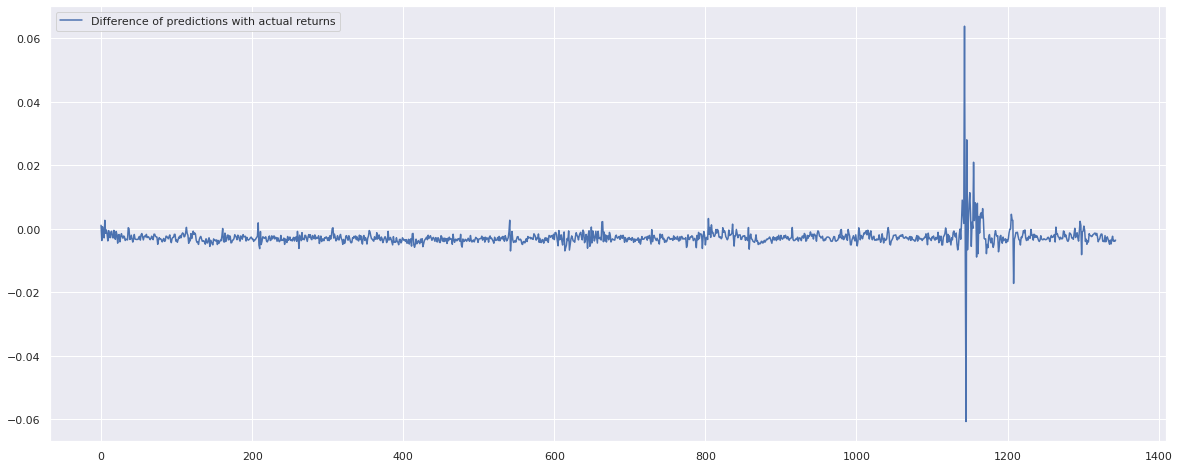

In [83]:
ax = plt.gca()
ax.plot(predicted_returns - target_returns, label="Difference of predictions with actual returns")
plt.legend(loc='best')
plt.show()

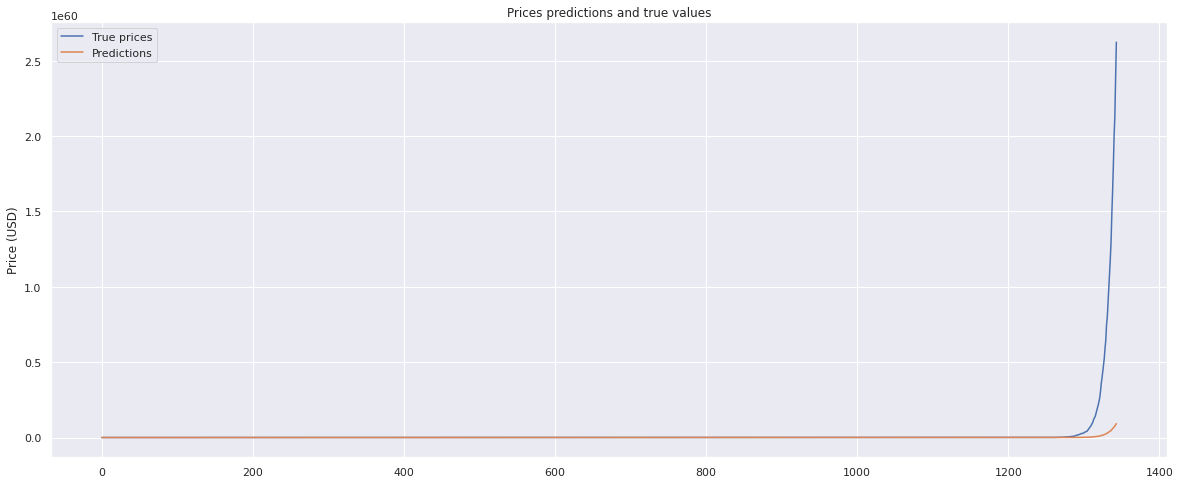

In [84]:
target_absolute = test_start_price * (1 + target_returns).cumprod()
predicted_absolute = test_start_price * (1 + predicted_returns).cumprod()

ax = plot_predictions(labels=target_absolute, predictions=predicted_absolute)

### Use of lime to explain decisions

In [9]:
import lime
from lime import lime_tabular

# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
training_samples = np.concatenate([x for x, y in train_set], axis=0)
training_labels = np.concatenate([y for x, y in train_set], axis=0)


for batch in train_set.take(1):
    inputs, targets = batch

explainer = lime_tabular.RecurrentTabularExplainer(inputs, training_labels=targets,
                                                   discretize_continuous = True,
                                                   feature_names=X_train,
                                                   verbose=True, mode='regression')

In [10]:
test_samples = np.concatenate([x for x, y in val_set], axis=0)

print(test_samples.shape)

(2690, 5, 12)


In [11]:
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb

import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(texplainer, test_samples, model.predict, 
                                        sample_size=15, num_features=10, num_exps_desired=5)

NameError: name 'texplainer' is not defined

In [ ]:
explanations = list(sp_obj.sp_explanations)

#print(len(explanations))

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]